<a href="https://colab.research.google.com/github/MayerT1/PIPECAST/blob/main/PIPECAST_Sensitivity_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

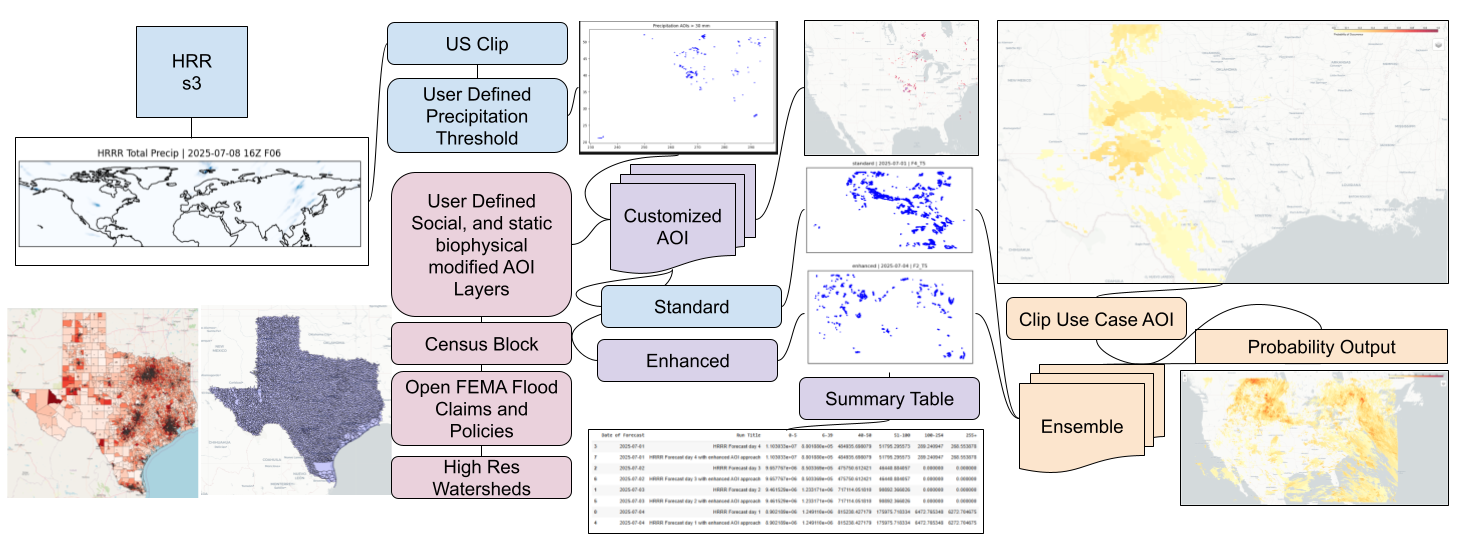

In [5]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Census Data

In [2]:
import geopandas as gpd

# Path to your joined shapefile
output_shp = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/NHGIS_Census_Tracts/texas_block_groups_with_pop.shp"

# Load it into a GeoDataFrame
census_gdf = gpd.read_file(output_shp)

# Check the first rows and columns
print(census_gdf.head())
print(census_gdf.columns)
print(census_gdf.crs)  # Check coordinate reference system

           GISJOIN STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID  \
0  G48000109501001      48      001  950100        1  480019501001   
1  G48000109501002      48      001  950100        2  480019501002   
2  G48000109501003      48      001  950100        3  480019501003   
3  G48000109504011      48      001  950401        1  480019504011   
4  G48000109504021      48      001  950402        1  480019504021   

        NAMELSAD  MTFCC FUNCSTAT        ALAND     AWATER     INTPTLAT  \
0  Block Group 1  G5030        S   15079443.0   134009.0  +32.0610630   
1  Block Group 2  G5030        S  228222245.0  5866624.0  +31.9532088   
2  Block Group 3  G5030        S  240004925.0  1863680.0  +31.9800959   
3  Block Group 1  G5030        S   16509268.0   298419.0  +31.7346372   
4  Block Group 1  G5030        S   71134275.0  2626492.0  +31.8000515   

       INTPTLON    Shape_Leng    Shape_Area  index_righ  U7H001  \
0  -095.4957453  21507.629535  1.521346e+07    200508.0  1196.0   
1  -09

# Watershed Data

In [3]:
import geopandas as gpd

# Path to your joined shapefile
watershed_output_shp = "/content/drive/Shareddrives/SCO-Shared/Science Resources/Thematic Service Areas/WaterSecurity/Pipecast/USGS_High_Res_Watersheds/texas_wbdhu12.shp"

# Load it into a GeoDataFrame
gdf_watershed_tx = gpd.read_file(watershed_output_shp)

# Check the first rows and columns
print(gdf_watershed_tx.head())
print(gdf_watershed_tx.columns)
print(gdf_watershed_tx.crs)  # Check coordinate reference system

                                    tnmid  \
0  {E16FD25F-A288-4A75-B389-3003417C7F44}   
1  {AF257BF1-071F-4382-8F25-BCEDCE620161}   
2  {F26C2669-3337-4264-9CB4-60F7344D1B0F}   
3  {3893E8BF-1265-2C0B-E054-0021286F9DF6}   
4  {7F62DB4E-1521-4BD0-BB1B-1E9E670D6028}   

                               metasource                        sourcedata  \
0  {2F42D1FB-7624-4C17-A5F6-ECFEE2271019}  Watershed Boundary Dataset (WBD)   
1  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
2  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
3  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   
4  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   

                                          sourceorig sourcefeat  \
0  Natural Resources and Conservation Service and...       None   
1  Natural Resources and Conservation Service and...       None   
2  Natural Resources and Conservation Service and... 

# Sensitivity Experiment  

In [14]:
# Pick a common CRS (WGS84 for mapping or projected CRS for area calcs)
target_crs = "EPSG:4326"

# forecast_aoi = gdf.to_crs(target_crs)
gdf_tx_census = census_gdf.to_crs(target_crs)
gdf_tx = gdf_watershed_tx.to_crs(target_crs)

## Paramaters

In [ ]:
# --- PARAMETERS ---
forecast_dates = ["2025-07-04", "2025-07-03", "2025-07-02", "2025-07-01"]
thresholds = [5, 39, 50, 100, 254, 255]  # threshold mm
forecast_methods = ["standard", "enhanced"]
target_crs = "EPSG:4326"
fxx_list = [0, 4, 8, 12, 16, 20, 24]  # forecast times to evaluate

In [ ]:
import os
import json
from datetime import datetime
import geopandas as gpd
import rasterio
from scipy.ndimage import label
from shapely.geometry import shape
from herbie import Herbie
import numpy as np


# --- OUTPUT DIRECTORY ---
out_dir = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment"
os.makedirs(out_dir, exist_ok=True)

results = {}

# --- LOOP OVER DAYS, METHODS, THRESHOLDS, FORECAST HOURS ---
for method in forecast_methods:
    method_dir = os.path.join(out_dir, method)
    os.makedirs(method_dir, exist_ok=True)
    results[method] = {}

    for date_str in forecast_dates:
        date_dir = os.path.join(method_dir, date_str)
        os.makedirs(date_dir, exist_ok=True)
        results[method][date_str] = {}

        date = datetime.strptime(date_str, "%Y-%m-%d")

        for fxx in fxx_list:
            # Load HRRR forecast
            H = Herbie(date, model="hrrr", product="sfc", fxx=fxx, verbose=False)
            ds = H.xarray("APCP:surface")
            precip_data = ds["tp"].values

            # Build transform for geolocation
            transform = rasterio.transform.from_bounds(
                float(ds.longitude.min()), float(ds.latitude.min()),
                float(ds.longitude.max()), float(ds.latitude.max()),
                ds.dims["x"], ds.dims["y"]
            )

            # Loop over thresholds
            for threshold in thresholds:
                mask = precip_data > threshold
                labeled, num_features = label(mask)
                shapes = list(rasterio.features.shapes(labeled.astype(np.int16), mask=mask, transform=transform))

                polygons = []
                ids = []
                mean_precips = []

                for geom, label_id in shapes:
                    if label_id == 0:
                        continue
                    poly = shape(geom)
                    if poly.area > 0.01:
                        aoi_mask = labeled == label_id
                        mean_precip = float(precip_data[aoi_mask].mean())
                        polygons.append(poly)
                        ids.append(label_id)
                        mean_precips.append(mean_precip)

                # Build AOI GeoDataFrame
                gdf_aoi = gpd.GeoDataFrame({
                    'id': ids,
                    'mean_precip_mm': mean_precips
                }, geometry=polygons, crs="EPSG:4326")

                # Intersect with Census and Watersheds
                census_intersect = gpd.overlay(gdf_aoi, gdf_tx_census, how='intersection')
                ws_intersect = gpd.overlay(gdf_aoi, gdf_tx, how='intersection')

                # Compute summary values
                census_pop_sum = census_intersect['U7H001'].sum() if not census_intersect.empty else 0
                ws_area_sum = ws_intersect.geometry.area.sum() if not ws_intersect.empty else 0

                # Store in results dict
                key = f"F{fxx}_T{threshold}"
                results[method][date_str][key] = {
                    'forecast_hour': fxx,
                    'num_aois': len(polygons),
                    'mean_precip_over_aois': np.mean(mean_precips) if mean_precips else 0,
                    'census_pop_sum': census_pop_sum,
                    'watershed_area_sum': ws_area_sum
                }

                # Save AOI GeoJSON
                out_gdf_path = os.path.join(date_dir, f"{key}_aois.geojson")
                gdf_aoi.to_file(out_gdf_path, driver="GeoJSON")

# Save results dictionary
summary_path = os.path.join(out_dir, "experiment_summary_with_fxx.json")
with open(summary_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Experiment complete. Results saved to {summary_path}")


## Plotting all AOIS

In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

root_dir = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment"

geojson_files = []
labels = []

for method in os.listdir(root_dir):
    method_dir = os.path.join(root_dir, method)
    if not os.path.isdir(method_dir):
        continue
    for date_str in os.listdir(method_dir):
        date_dir = os.path.join(method_dir, date_str)
        if not os.path.isdir(date_dir):
            continue
        for file in os.listdir(date_dir):
            if file.endswith(".geojson"):
                geojson_files.append(os.path.join(date_dir, file))
                label = f"{method} | {date_str} | {file.replace('_aois.geojson','')}"
                labels.append(label)

n_files = len(geojson_files)
n_cols = 4
n_rows = (n_files + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

for idx, (gjson, label) in enumerate(zip(geojson_files, labels)):
    gdf = gpd.read_file(gjson)
    ax = axes[idx]

    if not gdf.empty:
        gdf.boundary.plot(ax=ax, color='blue')
        ax.set_aspect('equal')
    else:
        ax.text(0.5, 0.5, 'No AOIs', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_aspect('auto')

    ax.set_title(label, fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Hide extra axes
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Mapping all AOIs

In [ ]:
import os
import folium
import geopandas as gpd

# --- ROOT DIRECTORY ---
root_dir = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment"

# --- Create base map (centered roughly over Texas for example) ---
m = folium.Map(location=[31.0, -99.0], zoom_start=6, tiles="CartoDB positron")

# --- Loop through all AOIs ---
for method in os.listdir(root_dir):
    method_dir = os.path.join(root_dir, method)
    if not os.path.isdir(method_dir):
        continue

    for date_str in os.listdir(method_dir):
        date_dir = os.path.join(method_dir, date_str)
        if not os.path.isdir(date_dir):
            continue

        for file in os.listdir(date_dir):
            if not file.endswith(".geojson"):
                continue

            gdf_aoi = gpd.read_file(os.path.join(date_dir, file))
            if gdf_aoi.empty:
                continue

            # Convert to WGS84 for folium
            gdf_aoi = gdf_aoi.to_crs("EPSG:4326")

            # Label for popup
            popup_label = f"{method} | {date_str} | {file.replace('_aois.geojson','')}"

            # Add to map
            folium.GeoJson(
                gdf_aoi,
                name=popup_label,
                tooltip=popup_label,
                style_function=lambda x: {
                    'fillColor': '#3186cc',
                    'color': '#3186cc',
                    'weight': 1,
                    'fillOpacity': 0.3
                }
            ).add_to(m)

# --- Add layer control ---
folium.LayerControl().add_to(m)

# --- Save and display ---
m.save(os.path.join(root_dir, "all_aois_map.html"))
m


## Table Summary

In [ ]:
import os
import geopandas as gpd
import pandas as pd

# --- ROOT DIRECTORY ---
root_dir = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment"

# --- Threshold bins & labels ---
bins = [(0, 5), (6, 39), (40, 50), (51, 100), (100, 254), (255, float('inf'))]
bin_labels = ["0-5", "6-39", "40-50", "51-100", "100-254", "255+"]

# --- Initialize results list ---
summary_rows = []

# --- Walk through experiment folder ---
for method in os.listdir(root_dir):
    method_dir = os.path.join(root_dir, method)
    if not os.path.isdir(method_dir):
        continue

    for date_str in os.listdir(method_dir):
        date_dir = os.path.join(method_dir, date_str)
        if not os.path.isdir(date_dir):
            continue

        # Prepare row dict for this run
        row = {
            "Date of Forecast": date_str,
            "Run Title": f"HRRR Forecast day {abs((pd.to_datetime('2025-07-04') - pd.to_datetime(date_str)).days)+1}" \
                         + (" with enhanced AOI approach" if method == "enhanced" else "")
        }
        # Initialize bin totals
        for label in bin_labels:
            row[label] = 0.0

        # Loop through AOI GeoJSONs
        for file in os.listdir(date_dir):
            if not file.endswith(".geojson"):
                continue

            # Parse threshold from filename (Fxx_T##)
            try:
                threshold = int(file.split("_T")[1].replace("_aois.geojson", ""))
            except:
                continue

            # Load AOIs and compute total area (in km²)
            gdf_aoi = gpd.read_file(os.path.join(date_dir, file))
            if gdf_aoi.empty:
                continue

            # Reproject to equal-area CRS for accurate area calculation
            gdf_aoi = gdf_aoi.to_crs("EPSG:6933")  # Cylindrical Equal Area
            total_area_km2 = gdf_aoi.geometry.area.sum() / 1e6

            # Find bin for threshold
            for (low, high), label in zip(bins, bin_labels):
                if low <= threshold <= high:
                    row[label] += total_area_km2
                    break

        summary_rows.append(row)

# --- Convert to DataFrame ---
df_summary = pd.DataFrame(summary_rows)

# --- Optional: sort by date & method ---
df_summary = df_summary.sort_values(by=["Date of Forecast", "Run Title"])

# --- Save to CSV ---
out_csv = os.path.join(root_dir, "sensitivity_area_summary.csv")
df_summary.to_csv(out_csv, index=False)

print(f"Summary table saved: {out_csv}")
df_summary


## Ensemble Approach

In [6]:
import os
import re
import json
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.crs import CRS
import matplotlib.pyplot as plt

# Optional folium preview
try:
    import folium
    from folium.raster_layers import ImageOverlay
    import branca.colormap as bcm
    USE_FOLIUM = True
except Exception:
    USE_FOLIUM = False

# ------------------------------
# Parameters
# ------------------------------
root_dir = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment"
out_dir  = os.path.join(root_dir, "ensemble_probability")
os.makedirs(out_dir, exist_ok=True)

# Threshold bins and labels
bins = [(0, 5), (6, 39), (40, 50), (51, 100), (100, 254), (255, float('inf'))]
bin_labels = ["0-5", "6-39", "40-50", "51-100", "100-254", "255+"]

# Grid resolution in degrees (adjust as needed; ~0.05° ~ 5–6 km near mid-lats)
res_deg = 0.05
crs = CRS.from_epsg(4326)  # WGS84 for simplicity/compatibility

# ------------------------------
# Gather all AOI files with metadata
# ------------------------------
pattern = re.compile(r"F(?P<fxx>\d+)_T(?P<thr>\d+)_aois\.geojson$")

members = []  # list of dicts with metadata and file path
all_bounds = []

for method in os.listdir(root_dir):
    method_dir = os.path.join(root_dir, method)
    if not os.path.isdir(method_dir):
        continue
    for date_str in os.listdir(method_dir):
        date_dir = os.path.join(method_dir, date_str)
        if not os.path.isdir(date_dir):
            continue
        for fn in os.listdir(date_dir):
            if not fn.endswith(".geojson"):
                continue
            m = pattern.search(fn)
            if not m:
                continue
            fxx = int(m.group("fxx"))
            thr = int(m.group("thr"))
            fpath = os.path.join(date_dir, fn)

            # Peek bounds (even empty files will load; guard empties later)
            gdf = gpd.read_file(fpath)
            if not gdf.empty:
                gdf = gdf.to_crs(epsg=4326)
                all_bounds.append(gdf.total_bounds.tolist())

            members.append({
                "method": method,
                "date": date_str,
                "fxx": fxx,
                "thr": thr,
                "path": fpath,
            })

if not members:
    raise RuntimeError("No AOI GeoJSON files found. Check your experiment output paths.")

# If everything was empty, set a default extent (fallback)
if not all_bounds:
    # Texas-ish fallback; adjust if needed
    west, south, east, north = (-107.0, 25.0, -93.0, 37.5)
else:
    all_bounds = np.array(all_bounds)
    west  = float(np.min(all_bounds[:,0]))
    south = float(np.min(all_bounds[:,1]))
    east  = float(np.max(all_bounds[:,2]))
    north = float(np.max(all_bounds[:,3]))

# Expand bounds by a small margin
pad = 0.25
west  -= pad
south -= pad
east  += pad
north += pad

# Build grid geometry
width  = int(np.ceil((east - west) / res_deg))
height = int(np.ceil((north - south) / res_deg))
transform = from_origin(west, north, res_deg, res_deg)

print(f"Grid: {width} x {height} @ {res_deg}°; bounds W{west:.3f} S{south:.3f} E{east:.3f} N{north:.3f}")

# ------------------------------
# Utility: map threshold value to bin label
# ------------------------------
def threshold_to_bin_label(thr: int) -> str:
    for (lo, hi), label in zip(bins, bin_labels):
        if lo <= thr <= hi:
            return label
    # default, shouldn't happen
    return "UNBINNED"

# ------------------------------
# Prepare accumulators per bin
# ------------------------------
counts_by_bin = {lbl: np.zeros((height, width), dtype=np.uint16) for lbl in bin_labels}
denom_by_bin  = {lbl: 0 for lbl in bin_labels}

# ------------------------------
# Rasterize each member into its bin
# ------------------------------
for mem in members:
    lbl = threshold_to_bin_label(mem["thr"])
    denom_by_bin[lbl] += 1  # this member contributes to denominator, even if empty

    gdf = gpd.read_file(mem["path"])
    if gdf.empty:
        continue

    # Ensure WGS84
    gdf = gdf.to_crs(epsg=4326)
    # Rasterize AOIs as 1s, then accumulate
    shapes = [(geom, 1) for geom in gdf.geometry if geom and not geom.is_empty]
    if not shapes:
        continue

    tmp = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        default_value=1,
        dtype=np.uint8
    )
    counts_by_bin[lbl] += tmp.astype(np.uint16)

# ------------------------------
# Compute probabilities and write GeoTIFFs
# ------------------------------
prob_paths = {}  # bin_label -> GeoTIFF path

for lbl in bin_labels:
    denom = denom_by_bin[lbl]
    if denom == 0:
        print(f"[WARN] No members found for bin {lbl}; skipping.")
        continue

    prob = counts_by_bin[lbl].astype(np.float32) / float(denom)  # 0..1
    prob = np.clip(prob, 0.0, 1.0)

    tif_path = os.path.join(out_dir, f"probability_{lbl.replace('+','plus')}.tif")
    profile = {
        "driver": "GTiff",
        "height": prob.shape[0],
        "width": prob.shape[1],
        "count": 1,
        "dtype": "float32",
        "crs": crs,
        "transform": transform,
        "compress": "lzw"
    }
    with rasterio.open(tif_path, "w", **profile) as dst:
        dst.write(prob, 1)

    prob_paths[lbl] = tif_path
    print(f"Saved {lbl} probability GeoTIFF -> {tif_path}")

# ------------------------------
# Optional: quick Folium viewer (writes PNG overlays)
# ------------------------------
if USE_FOLIUM and prob_paths:
    m = folium.Map(location=[(south+north)/2, (west+east)/2], zoom_start=6, tiles="CartoDB positron")

    for lbl, tif_path in prob_paths.items():
        with rasterio.open(tif_path) as src:
            arr = src.read(1)  # float32 0..1
            # Make a PNG (0..255) with alpha
            arr_norm = np.clip(arr, 0, 1)
            # Create RGBA (simple grayscale) for quick overlay
            rgba = np.zeros((arr_norm.shape[0], arr_norm.shape[1], 4), dtype=np.uint8)
            gray = (arr_norm * 255).astype(np.uint8)
            rgba[..., 0] = gray
            rgba[..., 1] = gray
            rgba[..., 2] = gray
            rgba[..., 3] = (arr_norm * 255).astype(np.uint8)  # alpha by probability

            png_path = os.path.join(out_dir, f"probability_{lbl.replace('+','plus')}.png")
            # Save PNG
            plt.figure(figsize=(6,6))
            plt.axis('off')
            plt.imshow(rgba)
            plt.savefig(png_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            # Overlay bounds
            b = src.bounds  # left, bottom, right, top
            img_overlay = ImageOverlay(
                name=f"Prob {lbl}",
                image=png_path,
                bounds=[[b.bottom, b.left], [b.top, b.right]],
                opacity=0.7,
                interactive=False,
                cross_origin=False
            )
            img_overlay.add_to(m)

        # Add a legend (shared)
    folium.LayerControl(collapsed=False).add_to(m)
    html_path = os.path.join(out_dir, "ensemble_probability_map.html")
    m.save(html_path)
    print(f"Folium map saved -> {html_path}")

# ------------------------------
# Also save a small JSON manifest for reproducibility
# ------------------------------
manifest = {
    "root_dir": root_dir,
    "out_dir": out_dir,
    "grid": {
        "bounds": {"west": west, "south": south, "east": east, "north": north},
        "resolution_deg": res_deg,
        "width": width, "height": height,
        "crs": "EPSG:4326"
    },
    "bins": [{"label": l, "range": r} for l, r in zip(bin_labels, bins)],
    "denominators": denom_by_bin,
    "probability_tifs": prob_paths
}
with open(os.path.join(out_dir, "ensemble_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)
print("Wrote ensemble_manifest.json")


Grid: 1331 x 639 @ 0.05°; bounds W232.773 S20.918 E299.292 N52.836
Saved 0-5 probability GeoTIFF -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_0-5.tif
Saved 6-39 probability GeoTIFF -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_6-39.tif
Saved 40-50 probability GeoTIFF -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_40-50.tif
Saved 51-100 probability GeoTIFF -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_51-100.tif
Saved 100-254 probability GeoTIFF -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_100-254.tif
Sav

Map saved -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/ensemble_probability_color_map.html



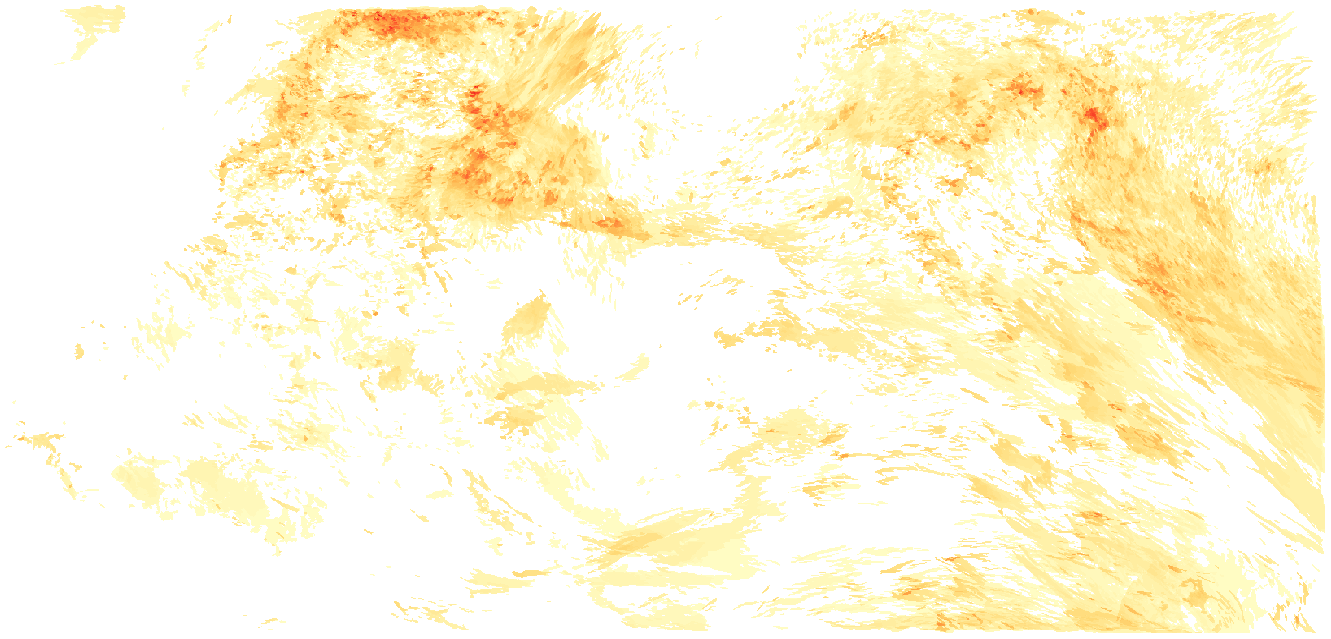
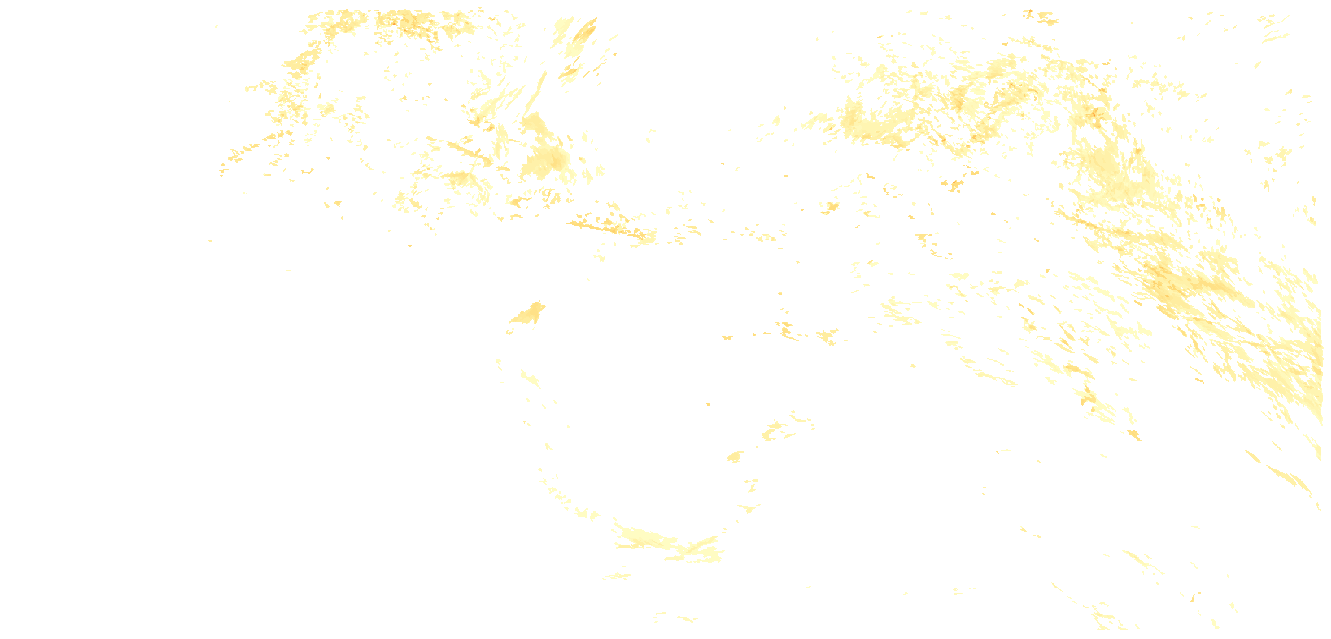
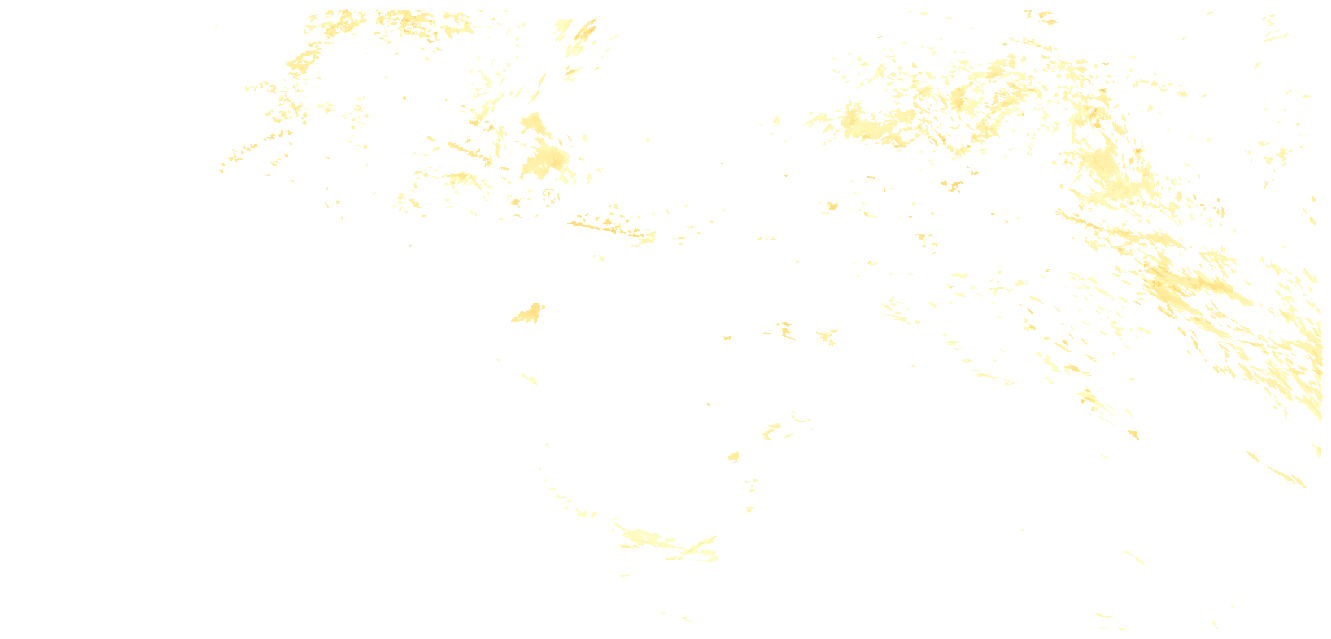
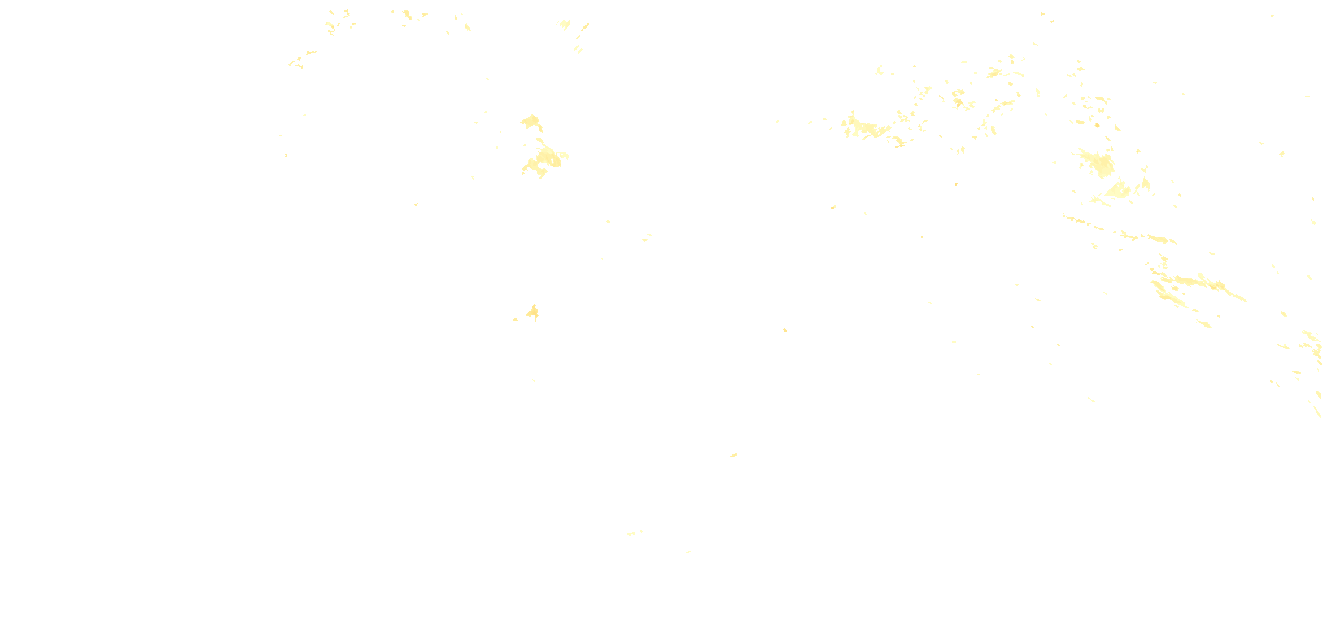
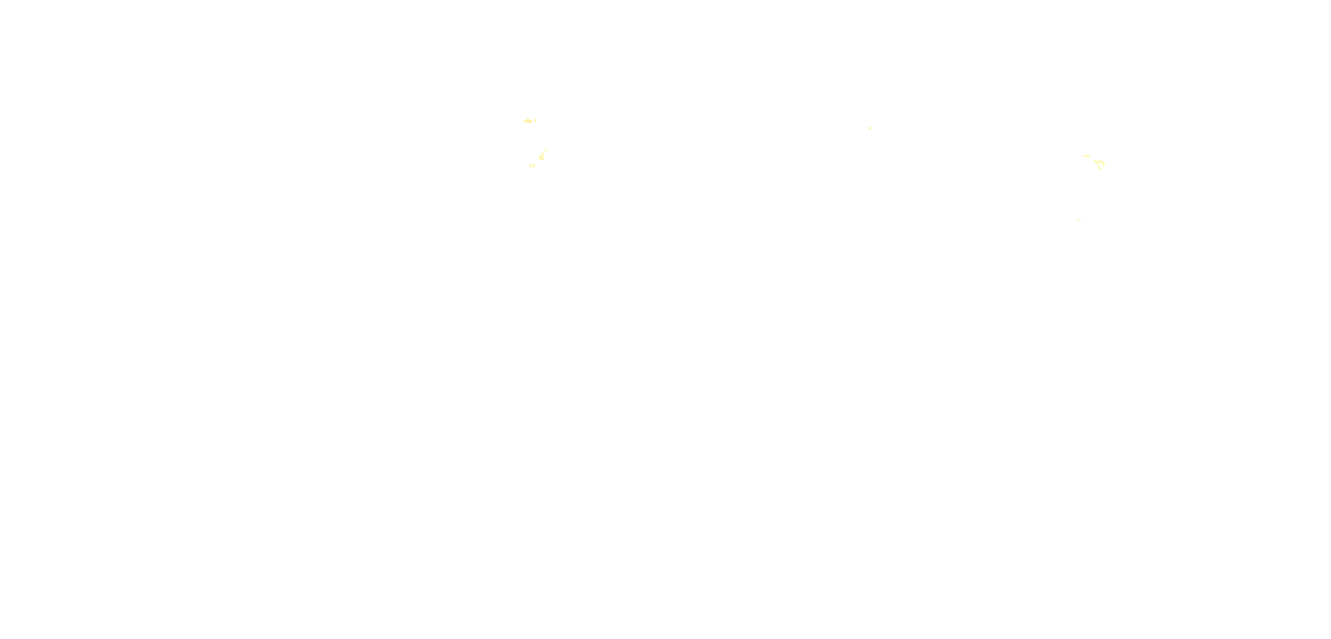
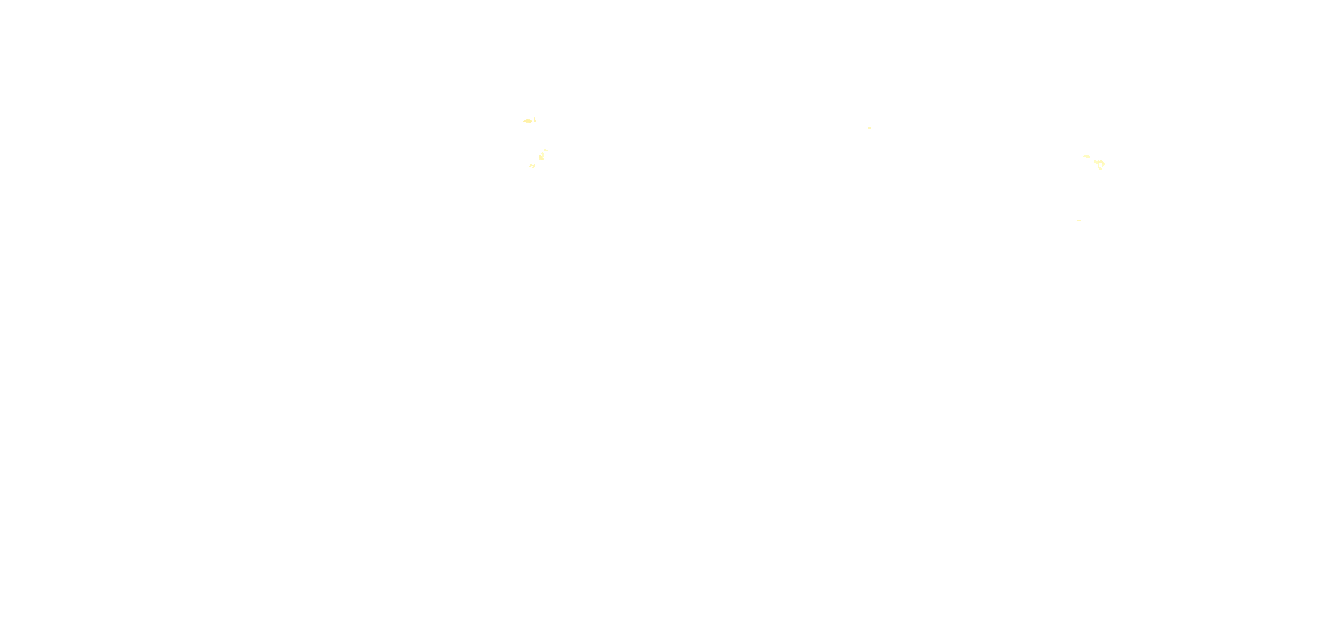

In [11]:
import folium
import rasterio
import numpy as np
import branca.colormap as cm
import matplotlib.colors as mcolors
from IPython.display import display

# Paths to your probability GeoTIFFs
prob_files = [
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_0-5.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_6-39.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_40-50.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_51-100.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_100-254.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_255plus.tif"
]

# Create continuous colormap (Yellow→Orange→Red)
colormap = cm.linear.YlOrRd_09.scale(0, 1)

# Initialize folium map
m = folium.Map(location=[37, -96], zoom_start=4, tiles="CartoDB positron")

for tif_path in prob_files:
    label = tif_path.split("/")[-1].replace("probability_", "").replace(".tif", "")

    with rasterio.open(tif_path) as src:
        arr = src.read(1).astype(float)
        arr = np.where(np.isnan(arr), 0, arr)  # Replace NaN with 0

        bounds = [[src.bounds.bottom, src.bounds.left],
                  [src.bounds.top, src.bounds.right]]

        # Apply colormap to nonzero values, fallback transparent for 0
        hex_list = [colormap(v) if v > 0 else "#00000000" for v in arr.flatten()]

        # Convert hex → RGBA (0–255 uint8)
        rgba_list = (mcolors.to_rgba_array(hex_list) * 255).astype(np.uint8)

        # Reshape back to (height, width, 4)
        rgba_img = rgba_list.reshape(arr.shape[0], arr.shape[1], 4)

        folium.raster_layers.ImageOverlay(
            image=rgba_img,
            bounds=bounds,
            name=f"Prob {label}",
            opacity=1.0  # now opacity is per-pixel
        ).add_to(m)

# Add legend & controls
colormap.caption = "Probability of Occurrence"
colormap.add_to(m)
folium.LayerControl().add_to(m)

out_html = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/ensemble_probability_color_map.html"
m.save(out_html)
print(f"Map saved -> {out_html}")
display(m)


## Clip Ensemble to Texas

/tmp/ipython-input-1509492153.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [texas_geom.unary_union.__geo_interface__]


✅ Clipped and saved: /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/probability_0-5.tif


/tmp/ipython-input-1509492153.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [texas_geom.unary_union.__geo_interface__]


✅ Clipped and saved: /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/probability_6-39.tif


/tmp/ipython-input-1509492153.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [texas_geom.unary_union.__geo_interface__]


✅ Clipped and saved: /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/probability_40-50.tif


/tmp/ipython-input-1509492153.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [texas_geom.unary_union.__geo_interface__]


✅ Clipped and saved: /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/probability_51-100.tif


/tmp/ipython-input-1509492153.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [texas_geom.unary_union.__geo_interface__]


✅ Clipped and saved: /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/probability_100-254.tif


/tmp/ipython-input-1509492153.py:43: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [texas_geom.unary_union.__geo_interface__]


✅ Clipped and saved: /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/probability_255plus.tif
Map saved -> /content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas/ensemble_probability_texas_map.html



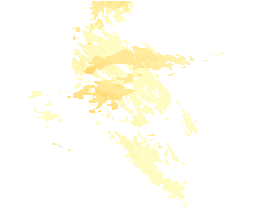
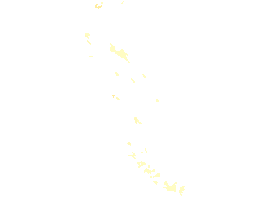
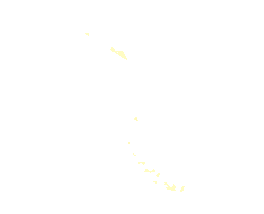
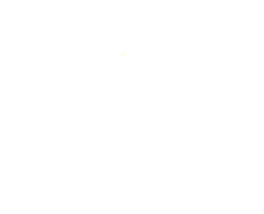
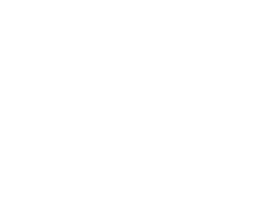
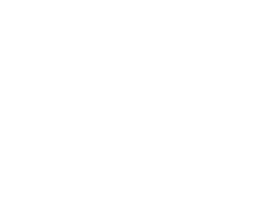

In [17]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
from shapely.affinity import translate
from pathlib import Path
import folium
import branca.colormap as cm
import matplotlib.colors as mcolors
from IPython.display import display

# -------------------------------------------------
# 1) Clip probability rasters to Texas boundaries
# -------------------------------------------------
target_crs = "EPSG:4326"
gdf_tx_census = gdf_tx_census.to_crs(target_crs)

prob_files = [
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_0-5.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_6-39.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_40-50.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_51-100.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_100-254.tif",
    "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/probability_255plus.tif"
]

out_dir = Path("/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/Sensitivity_Experiment/ensemble_probability/clipped_texas")
out_dir.mkdir(parents=True, exist_ok=True)

clipped_files = []

for tif_path in prob_files:
    with rasterio.open(tif_path) as src:
        bounds = src.bounds
        is_wrapped = bounds.left > 180

        if is_wrapped:
            texas_geom = gdf_tx_census.copy()
            texas_geom["geometry"] = texas_geom.translate(xoff=360)
        else:
            texas_geom = gdf_tx_census

        shapes = [texas_geom.unary_union.__geo_interface__]

        try:
            out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform
            })

            out_path = out_dir / Path(tif_path).name
            with rasterio.open(out_path, "w", **out_meta) as dest:
                dest.write(out_image)
            clipped_files.append(str(out_path))

            print(f"✅ Clipped and saved: {out_path}")

        except ValueError as e:
            print(f"⚠️ Skipping {tif_path} — no overlap with Texas: {e}")

# -------------------------------------------------
# 2) Add clipped rasters to Folium map
# -------------------------------------------------
colormap = cm.linear.YlOrRd_09.scale(0, 1)
m = folium.Map(location=[31, -99], zoom_start=6, tiles="CartoDB positron")

for tif_path in clipped_files:
    label = Path(tif_path).stem.replace("probability_", "")

    with rasterio.open(tif_path) as src:
        arr = src.read(1).astype(float)
        arr = np.where(np.isnan(arr), 0, arr)  # NaN → 0

        bounds = [[src.bounds.bottom, src.bounds.left],
                  [src.bounds.top, src.bounds.right]]

        # Apply colormap
        hex_list = [colormap(v) for v in arr.flatten()]
        rgba_list = (mcolors.to_rgba_array(hex_list) * 255).astype(np.uint8)

        # Make probability == 0 fully transparent
        mask_zero = arr.flatten() == 0
        rgba_list[mask_zero, 3] = 0  # Alpha channel → 0

        rgba_img = rgba_list.reshape(arr.shape[0], arr.shape[1], 4)

        folium.raster_layers.ImageOverlay(
            image=rgba_img,
            bounds=bounds,
            name=f"Prob {label}",
            opacity=1.0
        ).add_to(m)

colormap.caption = "Probability of Occurrence"
colormap.add_to(m)
folium.LayerControl().add_to(m)

out_html = str(out_dir / "ensemble_probability_texas_map.html")
m.save(out_html)
print(f"Map saved -> {out_html}")
display(m)


# Bring in Flight captured UAV flood map product to be considered truth

In [ ]:
# 4. Visualize all downloaded _UNet_class.tif files on a map with color legend
import folium
import rasterio
import numpy as np
import matplotlib.colors as mcolors
import os
from folium.raster_layers import ImageOverlay

# Folder containing downloaded files
folder_path = "/content/drive/Shareddrives/SCO-Shared/Thematic Service Areas/WaterSecurity/Pipecast/UAV_Collection/"

# Find all _UNet_class.tif files
tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith("_UNet_class.tif")]

# Create a base map (centered on the first raster)
with rasterio.open(tif_files[0]) as r:
    bounds = r.bounds
    m = folium.Map(location=[(bounds.top + bounds.bottom)/2, (bounds.left + bounds.right)/2],
                   zoom_start=12)

# Custom color ramp and class descriptions
class_colors = {
    1: {"color": "#1f78b4", "label": "Water"},
    2: {"color": "#33a02c", "label": "Vegetation"},
    3: {"color": "#e31a1c", "label": "Built-up"},
    4: {"color": "#ff7f00", "label": "Bare Soil"}
}
colors = [v["color"] for v in class_colors.values()]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=[1,2,3,4,5], ncolors=cmap.N)

# Loop over all rasters
for tif in tif_files:
    with rasterio.open(tif) as raster:
        data = raster.read(1)

        # Mask zeros
        masked_data = np.ma.masked_equal(data, 0)

        # Convert masked data to RGBA image
        rgba_img = cmap(norm(masked_data.filled(1)))  # fill masked with 1 to map to first color
        rgba_img = (rgba_img * 255).astype(np.uint8)

        # Make masked pixels fully transparent
        rgba_img[masked_data.mask, 3] = 0

        # Get raster bounds
        bounds = raster.bounds

        # Overlay the image
        layer_name = os.path.basename(tif)
        ImageOverlay(
            image=rgba_img,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=0.8,
            interactive=True,
            cross_origin=False,
            name=layer_name,
            zindex=1
        ).add_to(m)

# Add layer control to toggle rasters
folium.LayerControl().add_to(m)

# Add a color legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 150px; height: 140px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; opacity: 0.9;
            padding: 10px;">
<b>Class Legend</b><br>
'''
for c, info in class_colors.items():
    legend_html += f'<i style="background:{info["color"]};width:15px;height:15px;float:left;margin-right:5px;"></i>{info["label"]}<br>'
legend_html += '</div>'

m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m


## Summary Table